In [1]:
!pip install gdown

In [2]:
!gdown https://drive.google.com/uc?id=1rbQ5aJ81741Tm9laKUu3-viwS6sLxuL1

Downloading...
From: https://drive.google.com/uc?id=1rbQ5aJ81741Tm9laKUu3-viwS6sLxuL1
To: /content/data.zip
2.20GB [00:14, 150MB/s]


In [3]:
!unzip /content/data.zip

Streaming output truncated to the last 5000 lines.
  inflating: Data Jpg/train/COVID-19/COVID19(23).jpg  
  inflating: Data Jpg/train/COVID-19/COVID19(230).jpg  
  inflating: Data Jpg/train/COVID-19/COVID19(231).jpg  
  inflating: Data Jpg/train/COVID-19/COVID19(232).jpg  
  inflating: Data Jpg/train/COVID-19/COVID19(233).jpg  
  inflating: Data Jpg/train/COVID-19/COVID19(234).jpg  
  inflating: Data Jpg/train/COVID-19/COVID19(235).jpg  
  inflating: Data Jpg/train/COVID-19/COVID19(236).jpg  
  inflating: Data Jpg/train/COVID-19/COVID19(237).jpg  
  inflating: Data Jpg/train/COVID-19/COVID19(238).jpg  
  inflating: Data Jpg/train/COVID-19/COVID19(239).jpg  
  inflating: Data Jpg/train/COVID-19/COVID19(24).jpg  
  inflating: Data Jpg/train/COVID-19/COVID19(240).jpg  
  inflating: Data Jpg/train/COVID-19/COVID19(241).jpg  
  inflating: Data Jpg/train/COVID-19/COVID19(242).jpg  
  inflating: Data Jpg/train/COVID-19/COVID19(243).jpg  
  inflating: Data Jpg/train/COVID-19/COVID19(244).jpg  

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

In [5]:
#Memuat semua gambar ke memori untuk pertama kali

#Memuat dataset pelatihan
IMAGE_SIZE = 224
BATCH_SIZE = 100
base_dir = os.path.join('data/train')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split = 0.2,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range = 0.1,    
    vertical_flip = True,
    fill_mode = "nearest")

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

#Memuat dataset pengujian
X_test = []
y_test = []
labels = ['COVID-19', 'NORMAL', 'VIRAL PNEUMONIA']

for i,label in enumerate(labels):
    folder = os.path.join("data/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(224,224,3))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Found 4116 images belonging to 3 classes.
Found 1028 images belonging to 3 classes.
Bentuk array dari dataset train (pelatihan) adalah: (100, 224, 224, 3) (100, 3)
Bentuk array dari dataset validation (validasi) adalah: (100, 224, 224, 3) (100, 3)
Bentuk array dari dataset test (pengujian) adalah: (1288, 224, 224, 3) (1288,)


In [7]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'COVID-19': 0, 'NORMAL': 1, 'VIRAL PNEUMONIA': 2}


In [8]:
!cat labels.txt

COVID-19
NORMAL
VIRAL PNEUMONIA

In [9]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

In [10]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

In [11]:
model = Sequential([
    layers.Conv2D(3, (3,3), padding="same", activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(16, (3,3), padding="same", activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    layers.MaxPool2D((2,2)), 
    layers.Conv2D(256, (3,3), padding="same", activation="relu"),
    layers.MaxPool2D((2,2)),   
    layers.Flatten(),
    layers.Dense(4096),
    layers.Dropout(0.1),
    layers.Dense(3),
    layers.Activation("softmax")
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])

In [13]:
history = model.fit(train_generator, 
                    epochs=100, 
                    validation_data=val_generator)

Epoch 1/100
42/42 [==============================] - 152s 4s/step - loss: 1.0008 - acc: 0.5417 - val_loss: 0.7437 - val_acc: 0.6644
Epoch 2/100
42/42 [==============================] - 147s 4s/step - loss: 0.6967 - acc: 0.6973 - val_loss: 0.5643 - val_acc: 0.7675
Epoch 3/100
42/42 [==============================] - 147s 4s/step - loss: 0.4016 - acc: 0.8357 - val_loss: 0.3693 - val_acc: 0.8687
Epoch 4/100
42/42 [==============================] - 145s 3s/step - loss: 0.3698 - acc: 0.8377 - val_loss: 0.3990 - val_acc: 0.8492
Epoch 5/100
42/42 [==============================] - 144s 3s/step - loss: 0.2938 - acc: 0.8907 - val_loss: 0.3039 - val_acc: 0.8862
Epoch 6/100
42/42 [==============================] - 145s 3s/step - loss: 0.2448 - acc: 0.9134 - val_loss: 0.2881 - val_acc: 0.8979
Epoch 7/100
42/42 [==============================] - 145s 3s/step - loss: 0.2334 - acc: 0.9046 - val_loss: 0.2737 - val_acc: 0.9037
Epoch 8/100
42/42 [==============================] - 144s 3s/step - loss: 0.

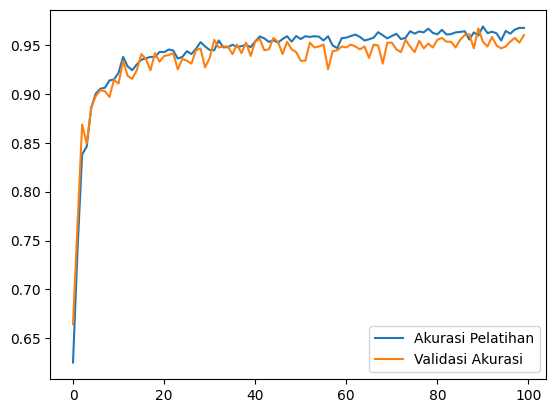

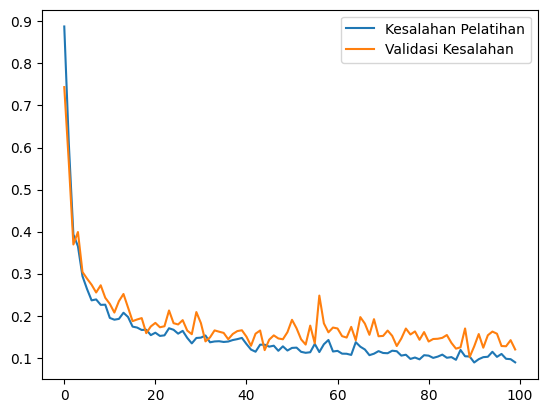

In [14]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

In [15]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 16


In [16]:
print(train_generator)

In [24]:
#Prediksi Label Validasi dengan Pelatihan
n = 40
input_image = image_batch[n][np.newaxis,...]
print("Labelnya adalah: ", label_batch[n])

predictions = model.predict(input_image)
print("Prediksinya adalah",predictions[0])

Labelnya adalah:  [0. 0. 1.]
Prediksinya adalah [1.3756585e-08 1.3993986e-04 9.9986005e-01]


In [25]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data training
print(model.evaluate(train_generator))
#Evaluasi validasi data
print(model.evaluate(val_generator))
#Evaluasi data test
print(model.evaluate(x= X_test3, y = y_test3)) 

['loss', 'acc']
42/42 [==============================] - 115s 3s/step - loss: 0.0775 - acc: 0.9723
[0.07748635113239288, 0.9723032116889954]
11/11 [==============================] - 30s 3s/step - loss: 0.1225 - acc: 0.9611
[0.12251115590333939, 0.9610894918441772]
41/41 [==============================] - 1s 10ms/step - loss: 0.1370 - acc: 0.9534
[0.1369558721780777, 0.9534161686897278]


In [26]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 ... 2 2 2]
[0 0 0 ... 2 2 2]


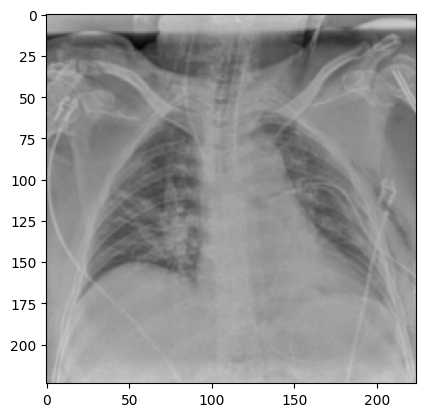

Label yang benar adalah: 0 : COVID-19
Nilai yang diprediksi adalah: [9.9959880e-01 1.5345468e-04 2.4776830e-04]
Label yang diprediksi adalah: 0 : COVID-19
Prediksi benar


In [31]:
n = 37 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")

Normalized confusion matrix
[[0.98 0.   0.02]
 [0.   0.9  0.1 ]
 [0.   0.03 0.97]]


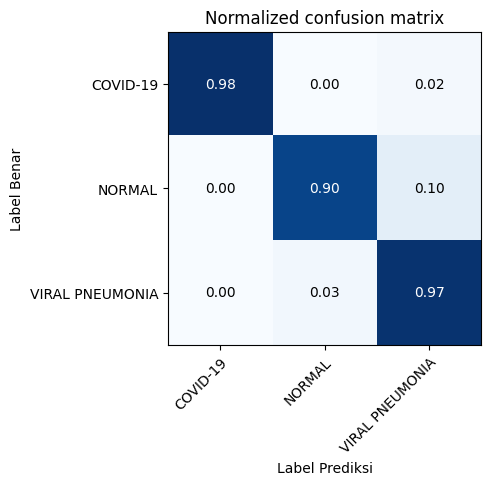

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

In [33]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('Klasifikasi_Covid_19_jpg_Final.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: save/model/assets
